In [4]:
# ============================================================
# NLCD 2023 -> Census tract % cover (ALL NLCD classes) — CONUS
#  - Zonal categorical counts (pixel counts by NLCD code)
#  - Convert to % of valid pixels in tract for each class code
#  - Rename columns to human-readable NLCD class names
#  - Save wide CSV (ONLY)
# ============================================================

import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats

# -------------------------
# 0) Paths (your server layout)
# -------------------------
BASE = Path("/mnt/sda-21.8/bdevoe/greenspace")

TRACTS_PATH = BASE / "resources" / "tracts" / "cb_2020_us_tract_500k.shp"
NLCD_TIF    = BASE / "nlcd" / "Annual_NLCD_LndCov_2023_CU_C1V1" / "Annual_NLCD_LndCov_2023_CU_C1V1.tif"

OUT_DIR = BASE / "processed" 
OUT_DIR.mkdir(parents=True, exist_ok=True)

OUT_CSV = OUT_DIR / "nlcd_2023_tract_fullclass_pct_cb2020_500k_CONUS_READABLE.csv"

# -------------------------
# 1) NLCD code -> name mapping (standard NLCD land cover classes)
# -------------------------
NLCD_CODE_TO_NAME = {
    11: "open_water",
    12: "perennial_ice_snow",
    21: "developed_open_space",
    22: "developed_low_intensity",
    23: "developed_medium_intensity",
    24: "developed_high_intensity",
    31: "barren_land",
    41: "deciduous_forest",
    42: "evergreen_forest",
    43: "mixed_forest",
    52: "shrub_scrub",
    71: "grassland_herbaceous",
    81: "pasture_hay",
    82: "cultivated_crops",
    90: "woody_wetlands",
    95: "emergent_herbaceous_wetlands",
}

# -------------------------
# 2) Helpers
# -------------------------
def filter_to_conus(tracts: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """Keep only CONUS states; drop AK, HI, PR, territories (by STATEFP)."""
    if "STATEFP" not in tracts.columns:
        raise ValueError("Expected STATEFP in tract shapefile (cb_2020_us_tract_500k).")
    exclude = {"02", "15", "60", "66", "69", "72", "78"}  # AK, HI, AS, GU, MP, PR, VI
    statefp = tracts["STATEFP"].astype(str).str.zfill(2)
    return tracts.loc[~statefp.isin(exclude)].copy()

def safe_int_codes(d):
    """Keep only integer NLCD codes from a zonal_stats dict."""
    if not d:
        return {}
    return {int(k): int(v) for k, v in d.items() if isinstance(k, (int, np.integer))}

def pct_col_name(code: int) -> str:
    """pct_<code> -> pct_<human_readable>"""
    name = NLCD_CODE_TO_NAME.get(code, f"class_{code}")
    return f"pct_{name}"

# -------------------------
# 3) Load inputs
# -------------------------
print("=== NLCD 2023 tract aggregation (ALL CLASSES) — CONUS ONLY ===")
print(f"Tracts: {TRACTS_PATH}")
print(f"NLCD:   {NLCD_TIF}")
print(f"Out:    {OUT_CSV}")

if not TRACTS_PATH.exists():
    raise FileNotFoundError(f"Missing tract file: {TRACTS_PATH}")
if not NLCD_TIF.exists():
    raise FileNotFoundError(f"Missing NLCD raster: {NLCD_TIF}")

tracts = gpd.read_file(TRACTS_PATH)

if "GEOID" not in tracts.columns:
    raise ValueError("Tracts file missing GEOID column.")
tracts = tracts[~tracts.geometry.is_empty & tracts.geometry.notnull()].copy()

# CONUS filter
n0 = len(tracts)
tracts = filter_to_conus(tracts)
print(f"Filtered to CONUS tracts: {len(tracts):,} of {n0:,} (dropped {n0 - len(tracts):,})")

# Raster metadata
with rasterio.open(NLCD_TIF) as src:
    raster_crs = src.crs
    raster_nodata = src.nodata

# Reproject tracts to raster CRS
if tracts.crs != raster_crs:
    tracts = tracts.to_crs(raster_crs)

# -------------------------
# 4) Zonal stats (categorical pixel counts)
# -------------------------
zs = zonal_stats(
    vectors=tracts.geometry,
    raster=str(NLCD_TIF),
    categorical=True,
    nodata=raster_nodata,
    all_touched=False,     # keep consistent w/ prior runs
    geojson_out=False
)

zs = [safe_int_codes(d) for d in zs]

valid_counts = np.array([sum(d.values()) if d else 0 for d in zs], dtype=np.int64)

# Collect ALL NLCD codes present anywhere
all_codes = sorted({code for d in zs for code in d.keys()})

# Dense counts table
counts = pd.DataFrame(0, index=np.arange(len(zs)), columns=all_codes, dtype=np.int64)
for i, d in enumerate(zs):
    for k, v in d.items():
        counts.at[i, k] = v

# -------------------------
# 5) Convert to percentages + readable names
# -------------------------
out = pd.DataFrame({
    "GEOID": tracts["GEOID"].astype(str).values,
    "valid_pixel_count": valid_counts
})

for code in all_codes:
    out[pct_col_name(code)] = np.where(
        out["valid_pixel_count"] > 0,
        100.0 * counts[code].astype(float) / out["valid_pixel_count"],
        np.nan
    )

# Optional sanity column (kept, but you can drop later)
pct_cols = [pct_col_name(c) for c in all_codes]
out["pct_sum"] = out[pct_cols].sum(axis=1)

# -------------------------
# 6) Save (ONLY)
# -------------------------
out.to_csv(OUT_CSV, index=False)
print("Done.")
print(f"Wrote: {OUT_CSV}")


=== NLCD 2023 tract aggregation (ALL CLASSES) — CONUS ONLY ===
Tracts: /mnt/sda-21.8/bdevoe/greenspace/resources/tracts/cb_2020_us_tract_500k.shp
NLCD:   /mnt/sda-21.8/bdevoe/greenspace/nlcd/Annual_NLCD_LndCov_2023_CU_C1V1/Annual_NLCD_LndCov_2023_CU_C1V1.tif
Out:    /mnt/sda-21.8/bdevoe/greenspace/processed/nlcd_2023_tract_fullclass_pct_cb2020_500k_CONUS_READABLE.csv
Filtered to CONUS tracts: 83,509 of 85,187 (dropped 1,678)
Done.
Wrote: /mnt/sda-21.8/bdevoe/greenspace/processed/nlcd_2023_tract_fullclass_pct_cb2020_500k_CONUS_READABLE.csv


Loading tracts: /mnt/sda-21.8/bdevoe/greenspace/resources/tracts/cb_2020_us_tract_500k.shp
CONUS tracts: 83509
Loading NLCD CSV: /mnt/sda-21.8/bdevoe/greenspace/processed/nlcd_2023_tract_fullclass_pct_cb2020_500k_CONUS_READABLE.csv
Detected 16 NLCD class columns:
['pct_open_water', 'pct_perennial_ice_snow', 'pct_developed_open_space', 'pct_developed_low_intensity', 'pct_developed_medium_intensity', 'pct_developed_high_intensity', 'pct_barren_land', 'pct_deciduous_forest', 'pct_evergreen_forest', 'pct_mixed_forest', 'pct_shrub_scrub', 'pct_grassland_herbaceous', 'pct_pasture_hay', 'pct_cultivated_crops', 'pct_woody_wetlands', 'pct_emergent_herbaceous_wetlands']


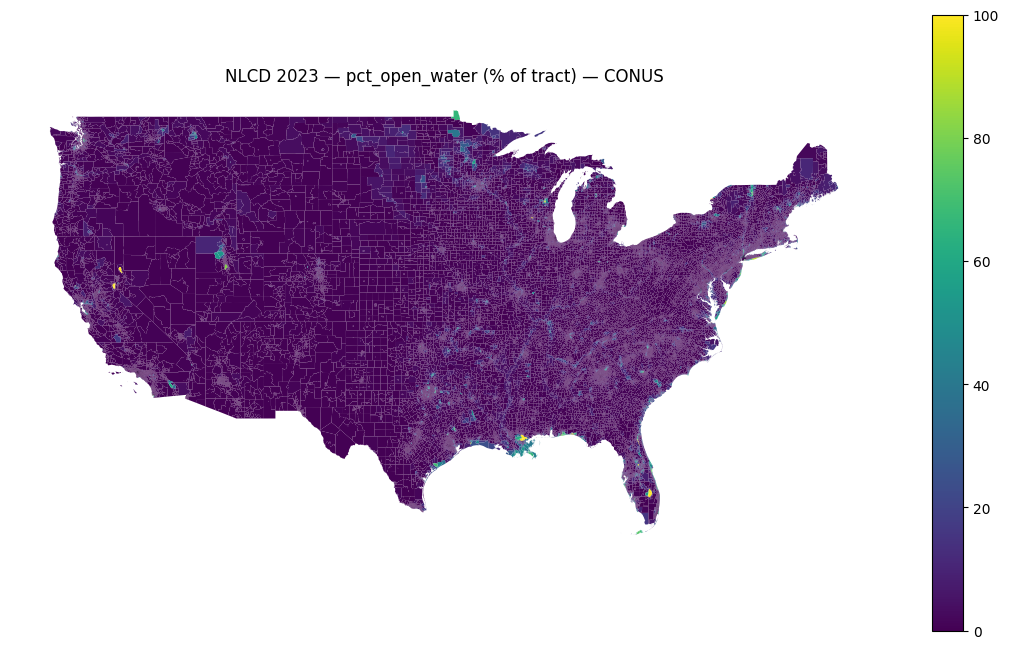

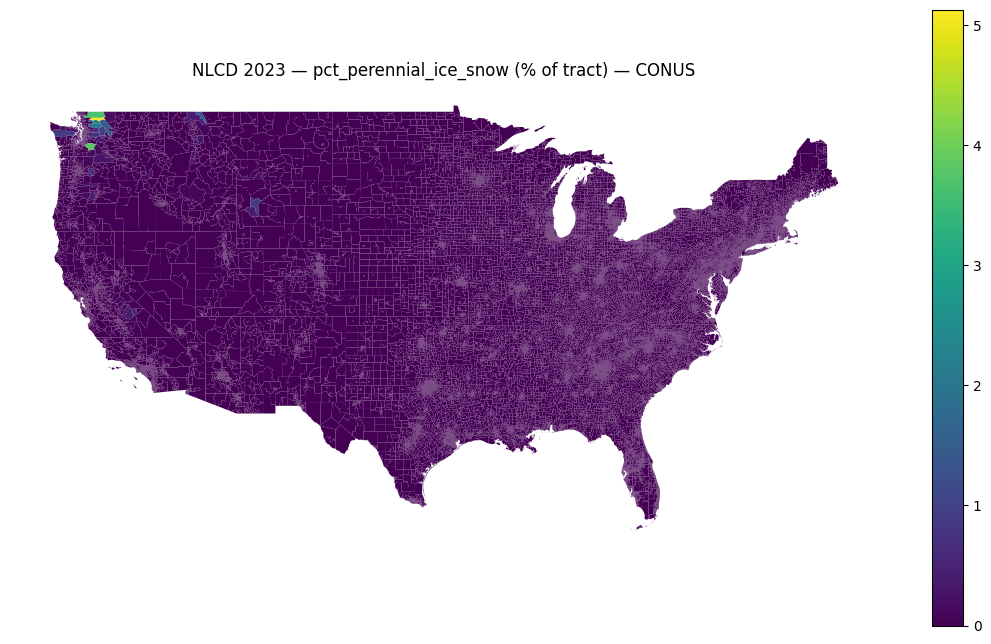

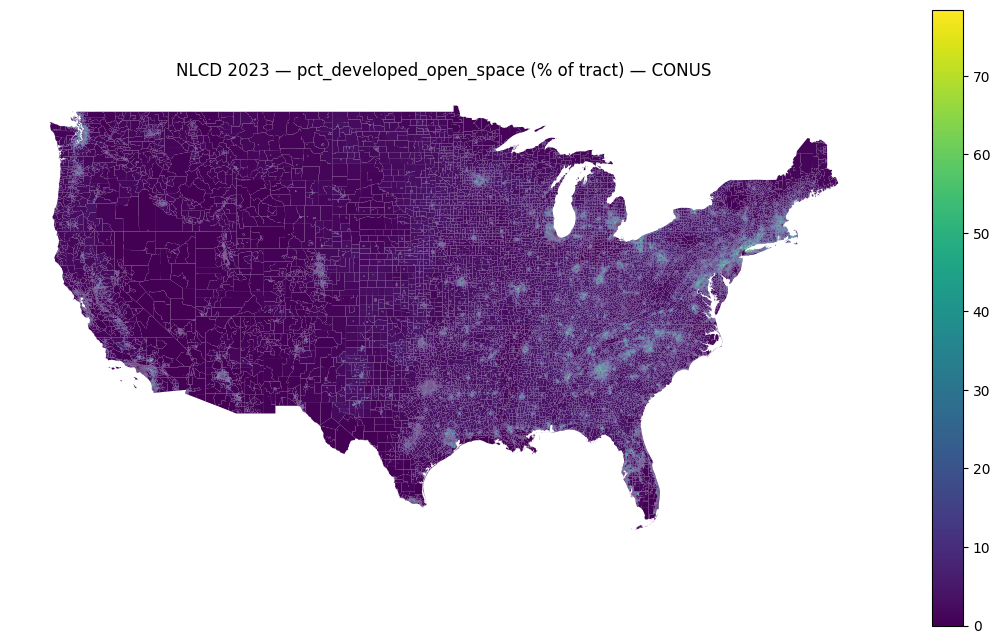

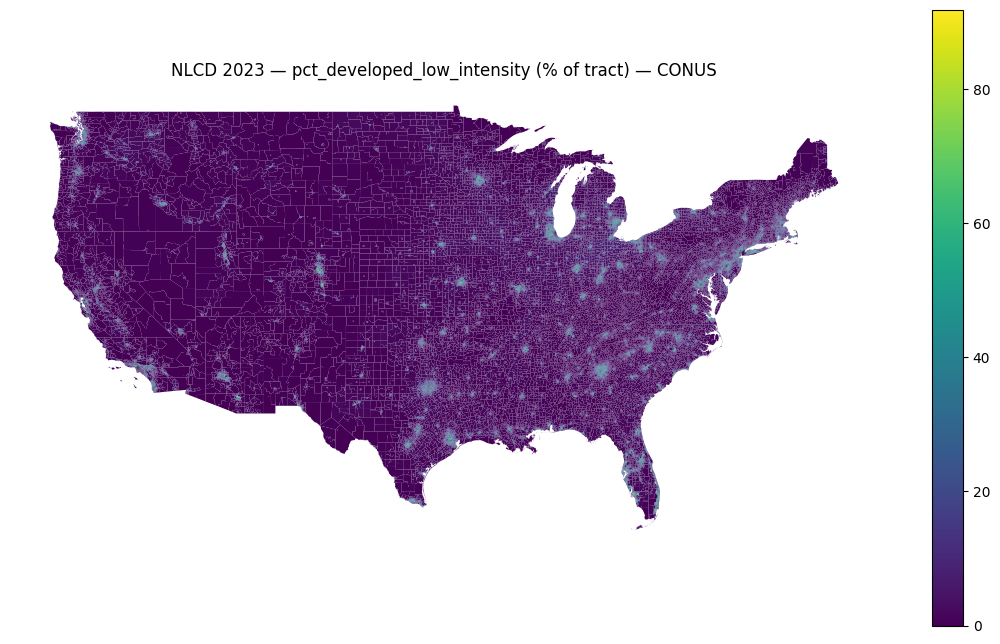

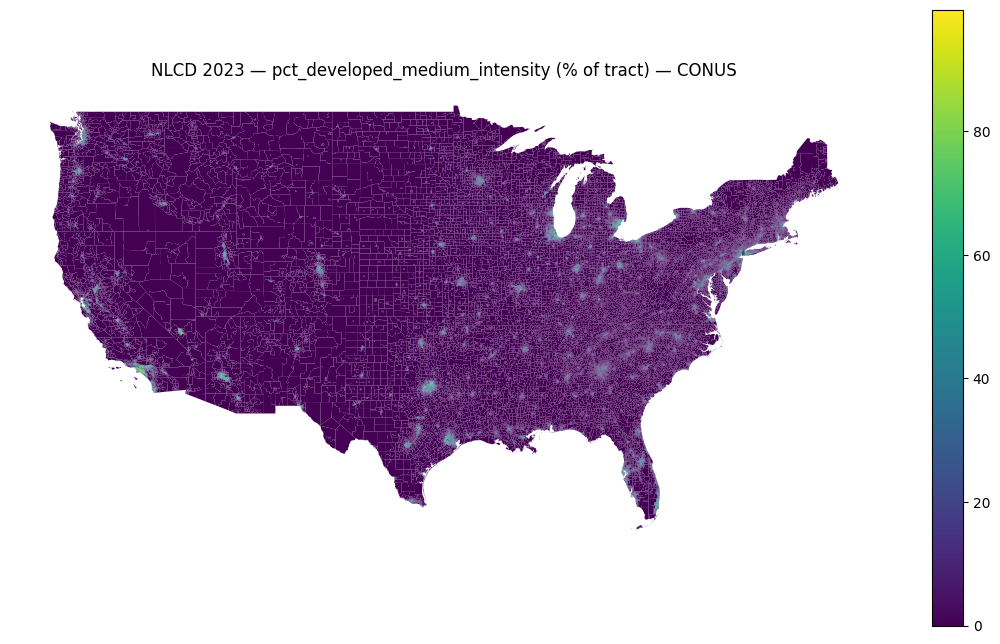

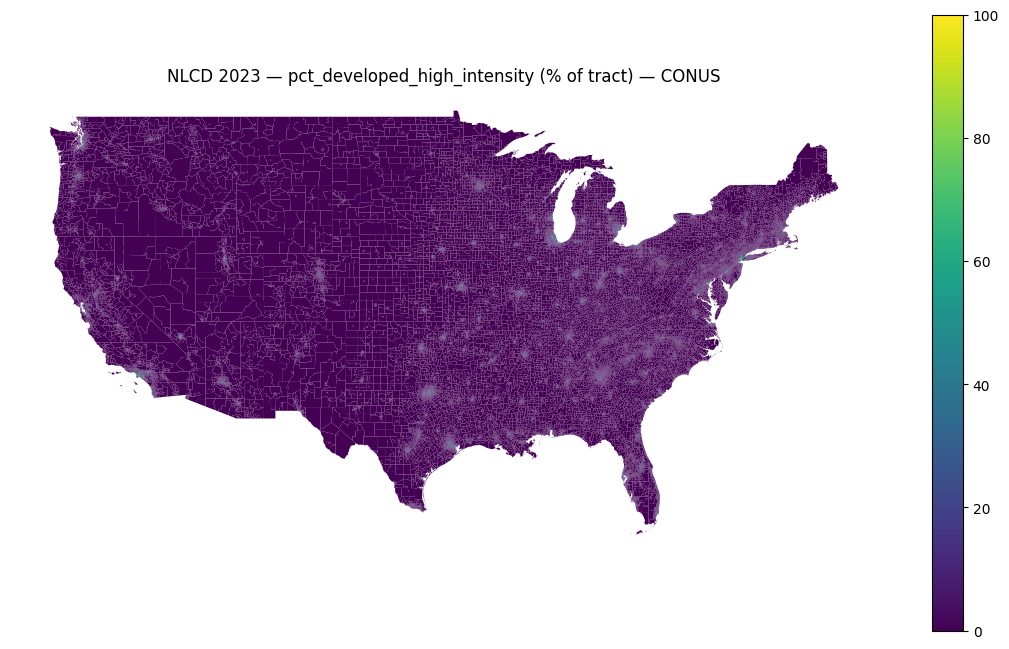

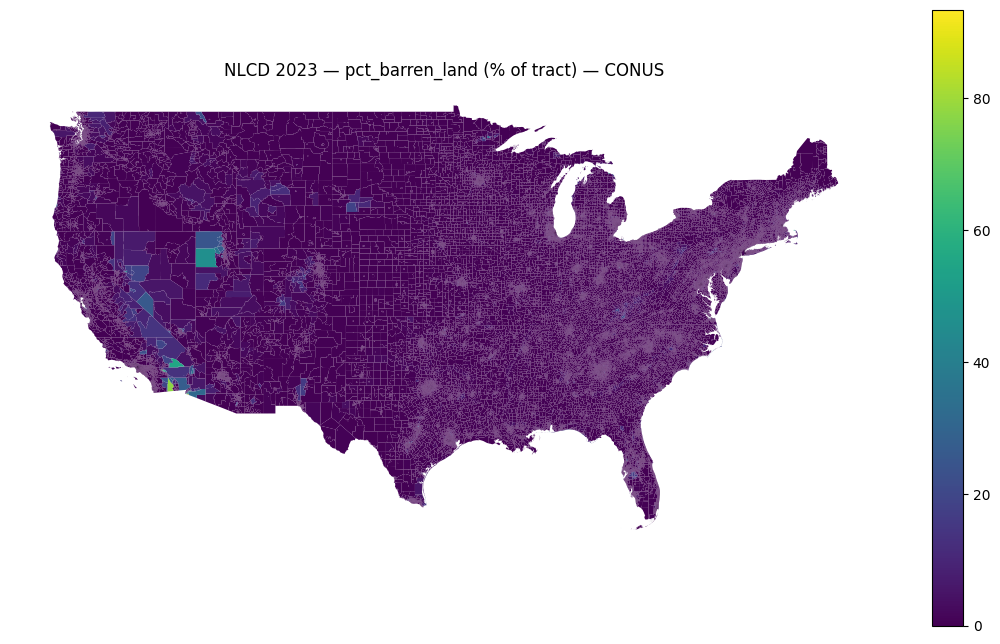

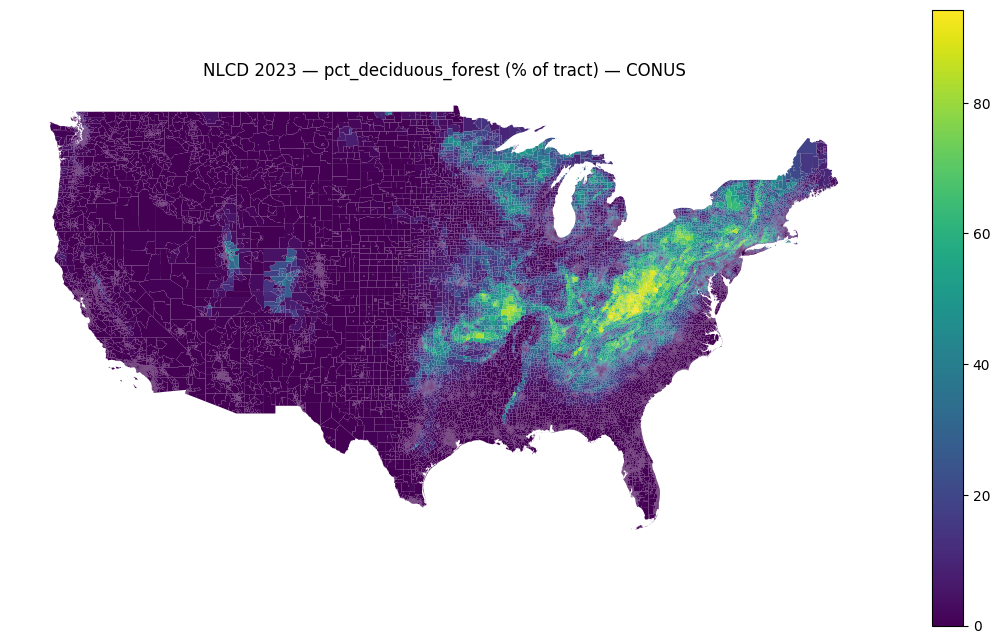

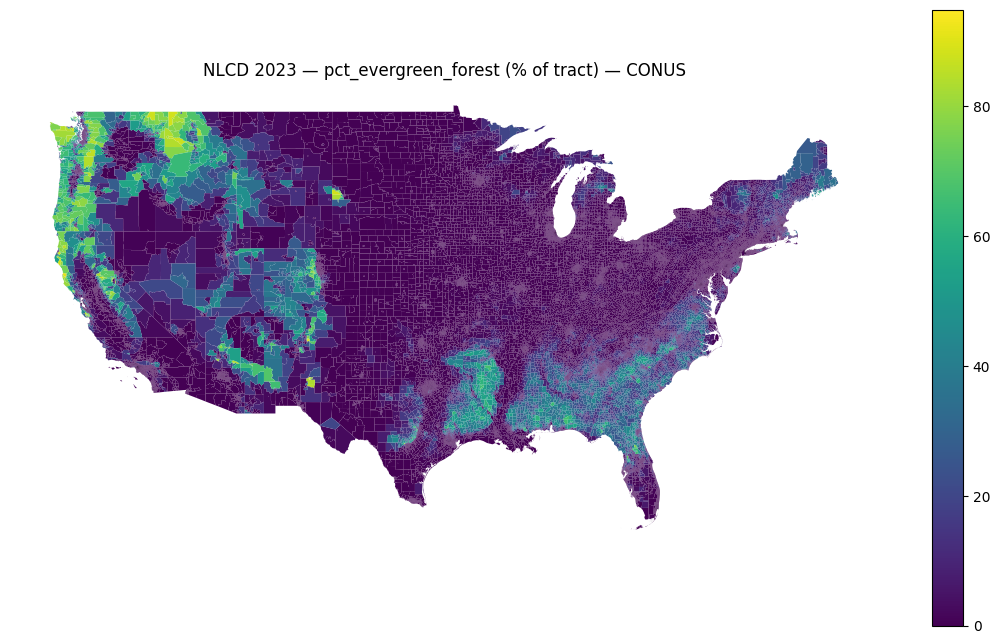

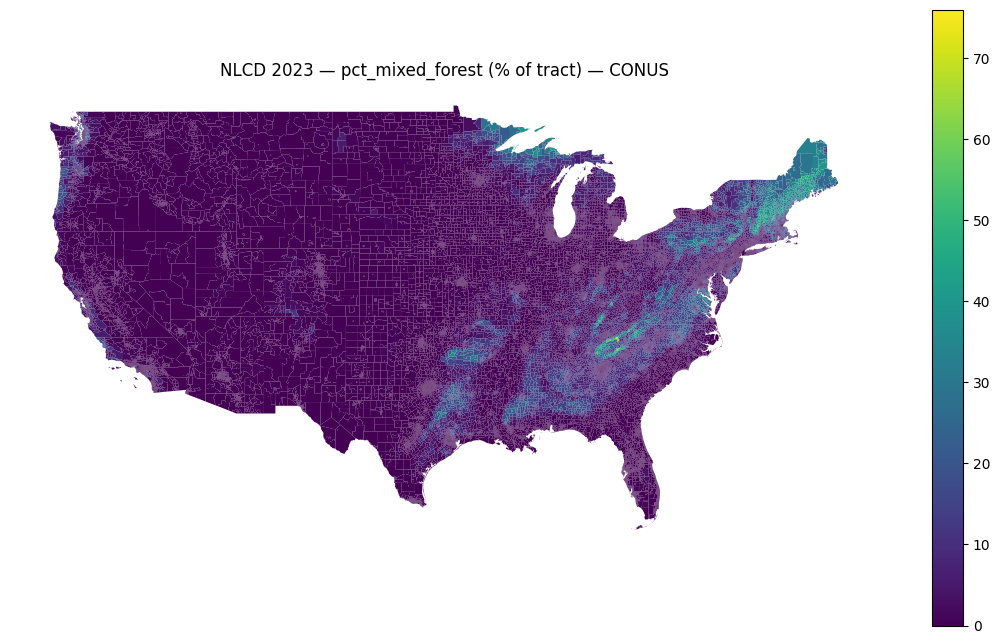

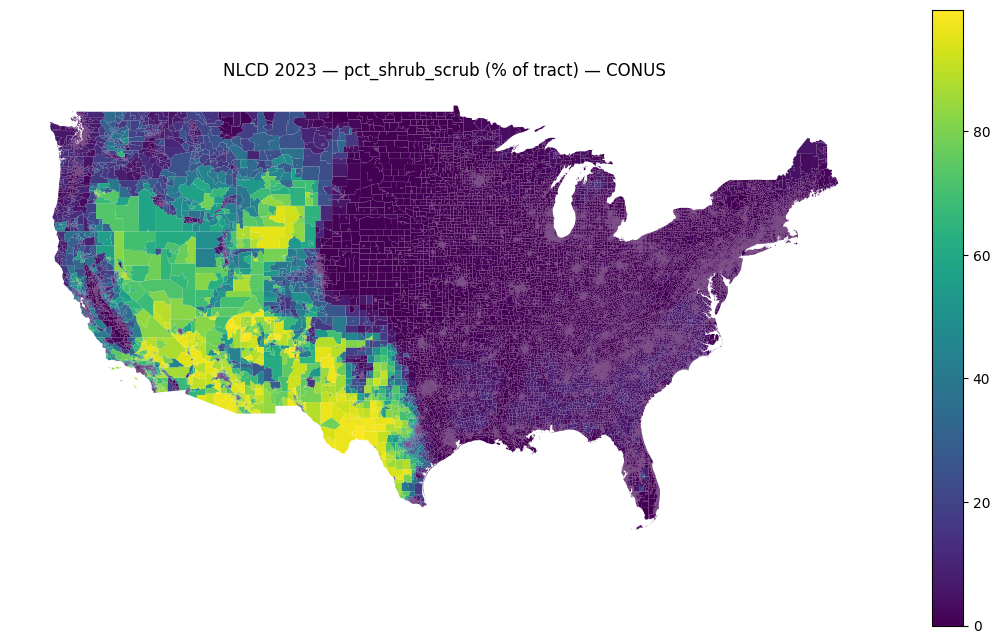

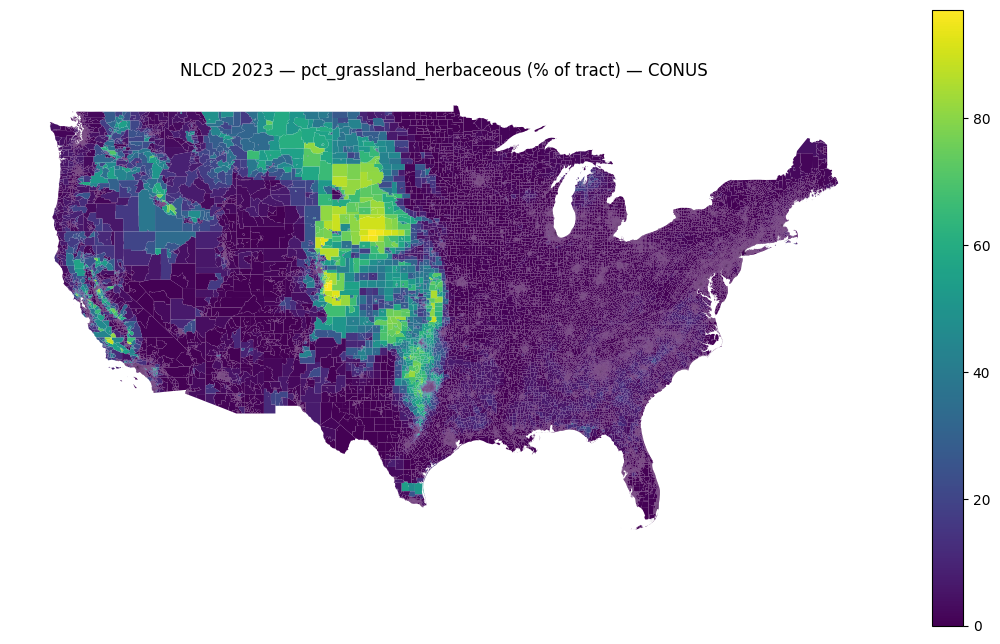

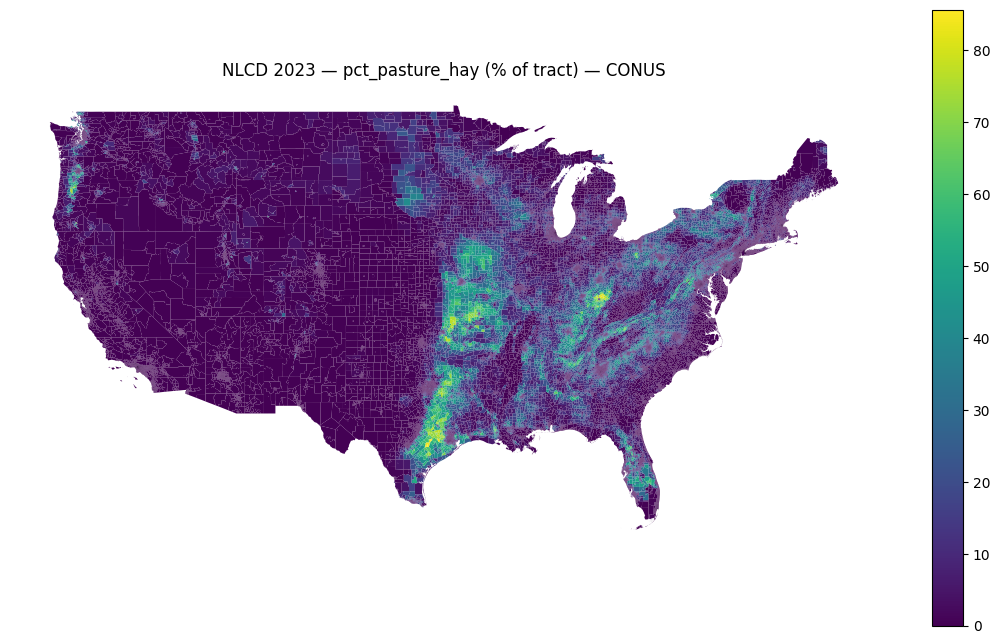

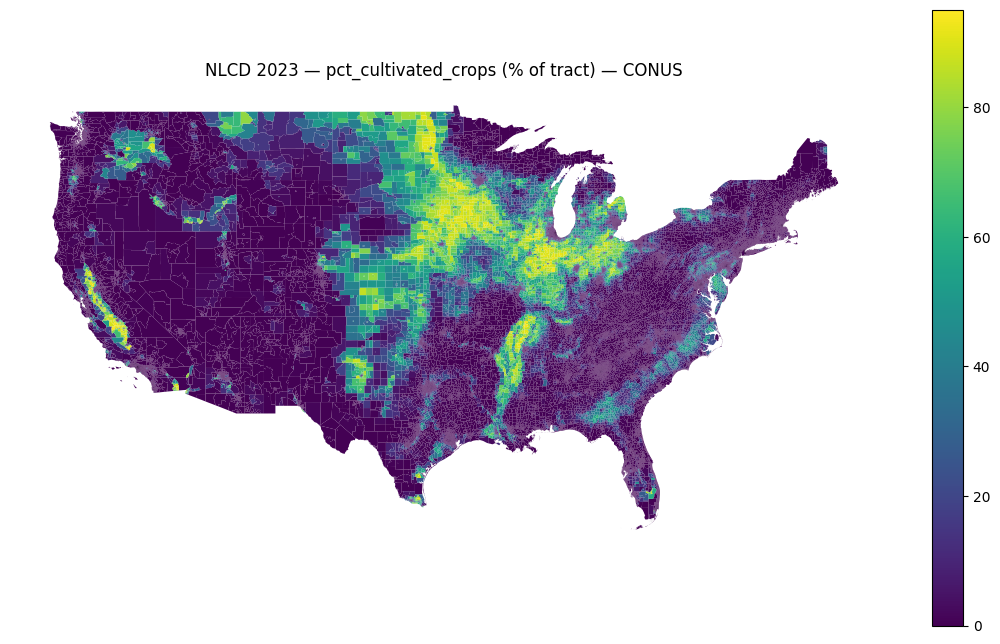

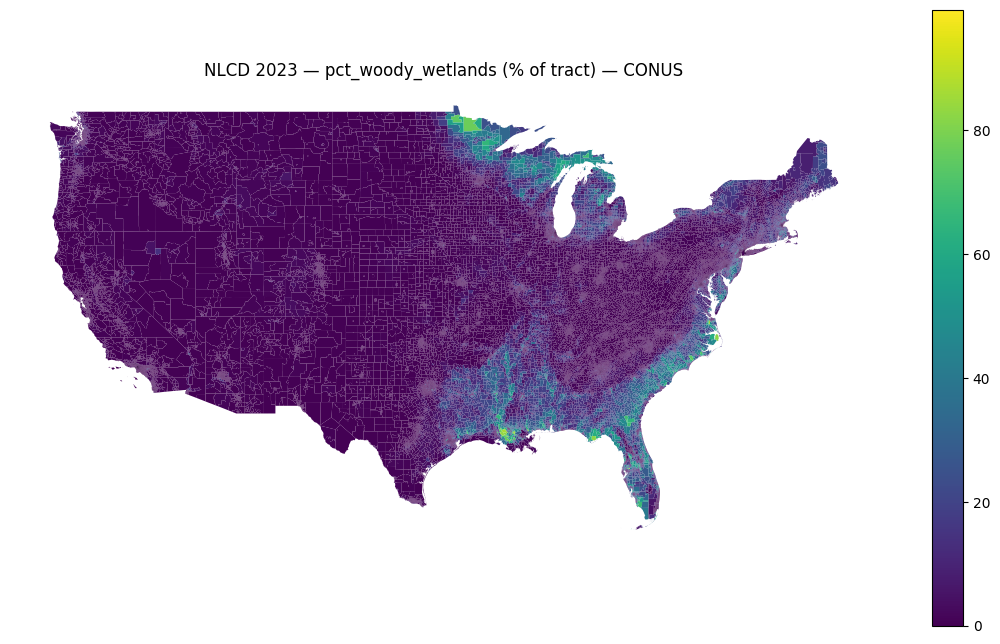

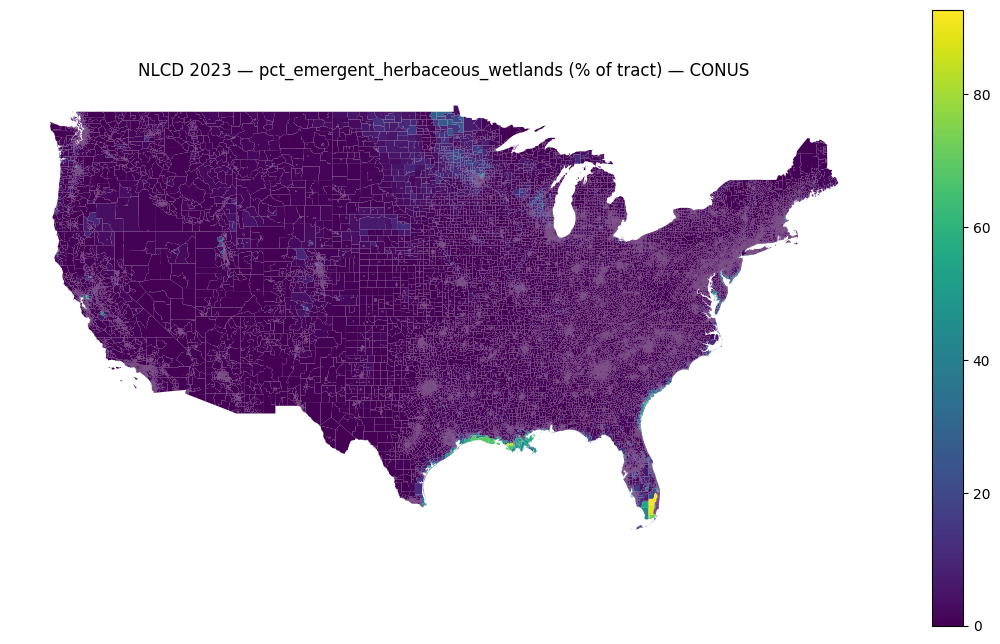

In [5]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# -------------------------
# Paths
# -------------------------
BASE = Path("/mnt/sda-21.8/bdevoe/greenspace")
TRACTS_SHP = BASE / "resources" / "tracts" / "cb_2020_us_tract_500k.shp"

# <-- change if needed
NLCD_CSV = BASE / "processed" / "nlcd_2023_tract_fullclass_pct_cb2020_500k_CONUS_READABLE.csv"

# -------------------------
# Helpers
# -------------------------
def filter_to_conus(tracts: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """Drop AK, HI, PR, and territories using STATEFP."""
    exclude = {"02", "15", "60", "66", "69", "72", "78"}  # AK, HI, AS, GU, MP, PR, VI
    statefp = tracts["STATEFP"].astype(str).str.zfill(2)
    return tracts.loc[~statefp.isin(exclude)].copy()

def pick_pct_cols(df: pd.DataFrame):
    """
    Accept either:
      - readable columns like nlcd_open_water_pct, nlcd_deciduous_forest_pct, ...
      - or code columns like pct_11, pct_21, ...
    Excludes pct_sum if present.
    """
    cols = []
    for c in df.columns:
        if c.startswith("nlcd_") and c.endswith("_pct"):
            cols.append(c)
        if c.startswith("pct_") and c != "pct_sum":
            cols.append(c)
    # keep order stable-ish
    seen = set()
    out = []
    for c in cols:
        if c not in seen:
            out.append(c)
            seen.add(c)
    return out

def plot_map(gdf: gpd.GeoDataFrame, col: str, title: str):
    fig, ax = plt.subplots(1, 1, figsize=(14, 8))
    gdf.plot(
        column=col,
        ax=ax,
        legend=True,
        linewidth=0,
        missing_kwds={"color": "lightgrey"}
    )
    ax.set_title(title)
    ax.set_axis_off()
    plt.show()

# -------------------------
# Load + merge
# -------------------------
print("Loading tracts:", TRACTS_SHP)
tracts = gpd.read_file(TRACTS_SHP)

if "GEOID" not in tracts.columns or "STATEFP" not in tracts.columns:
    raise ValueError("Expected GEOID and STATEFP in cb_2020_us_tract_500k shapefile.")

tracts = tracts[~tracts.geometry.is_empty & tracts.geometry.notnull()].copy()
tracts = filter_to_conus(tracts)
print("CONUS tracts:", len(tracts))

print("Loading NLCD CSV:", NLCD_CSV)
nlcd = pd.read_csv(NLCD_CSV, dtype={"GEOID": str})

gdf = tracts[["GEOID", "geometry"]].merge(nlcd, on="GEOID", how="left")

pct_cols = pick_pct_cols(nlcd)
print(f"Detected {len(pct_cols)} NLCD class columns:")
print(pct_cols)

# -------------------------
# Plot (one per class)
# -------------------------
for c in pct_cols:
    plot_map(gdf, c, f"NLCD 2023 — {c} (% of tract) — CONUS")
